<a href="https://colab.research.google.com/github/Sky0307/2022DLProject/blob/main/training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import h5py
import json
import librosa
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import time
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch import optim
import seaborn as sn

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
directory = "drive/MyDrive/datasets/"

# Default Params

In [4]:
class Parameters:
    def __init__(self):
        self.batch_size = None
        self.label_size = 10
        self.epoch_num = None
        self.sample_rate = 16000
        self.use_cuda = True
        self.cuda = torch.cuda.is_available() and self.use_cuda
        self.log_step = None
        self.dataset_len = None
        self.dictionary = {0: 'pop',
                           1: 'metal',
                           2: 'disco',
                           3: 'blues',
                           4: 'reggae',
                           5: 'classical',
                           6: 'rock',
                           7: 'hiphop',
                           8: 'country',
                           9: 'jazz'}
        self.r_dictionary = {'pop': 0,
                             'metal': 1,
                             'disco': 2,
                             'blues': 3,
                             'reggae': 4,
                             'classical': 5,
                             'rock': 6,
                             'hiphop': 7,
                             'country': 8,
                             'jazz': 9}

        # custom dataset
        self.TRAIN_DATA = directory + 'training dataset/custom_train.h5'
        self.VAL_DATA = directory + 'training dataset/custom_valid.h5'
        self.TEST_DATA = directory + 'training dataset/custom_test.h5'

        self.MODEL_SAVE_FOLDER = directory + 'model/'
        self.LOG_SAVE_FOLDER = directory + 'log/'

        if self.cuda:
            self.kwargs = {'num_workers': 1, 'pin_memory': True}
        else:
            self.kwargs = {}

        self.learning_rate = 1e-5

    def __str__(self):
        out_string = "The Batch Size is {0}\n" \
                     "The Label Size is {1}\n" \
                     "The Epoch Num is {2}\n" \
                     "The Cuda is set to {3}\n" \
                     "The log step is {4}".format(self.batch_size,
                                                  self.label_size,
                                                  self.epoch_num,
                                                  self.cuda,
                                                  self.log_step)
        return out_string

In [5]:
Para = Parameters()
Para.learning_rate = 1e-5
Para.batch_size = 20
Para.epoch_num = 40
print(Para)

The Batch Size is 20
The Label Size is 10
The Epoch Num is 40
The Cuda is set to True
The log step is None


In [6]:
class TorchData(Dataset):
  """
  To build the data loader
  """

  def __init__(self, dataset_path):
      """
      Take the h5py dataset
      """
      super(TorchData, self).__init__()
      self.dataset = h5py.File(dataset_path, 'r')
      self.mel = self.dataset['mel']
      self.tag = self.dataset['tag']

      self.len = self.mel.shape[0]

  def __len__(self):
      return self.len

  def __getitem__(self, index):
      mel = self.mel[index].astype(np.float32)
      mel = np.reshape(mel, (1, mel.shape[0], mel.shape[1]))
      mel = torch.from_numpy(mel)
      tag = torch.from_numpy(self.tag[index].astype(np.float32))
      sample = {"mel": mel, "tag": tag}

      return sample

In [7]:
# define the data loaders
def torch_dataset_loader(dataset, batch_size, shuffle, kwargs):
    """
    take the h5py dataset
    """
    loader = DataLoader(TorchData(dataset),
                        batch_size=batch_size,
                        shuffle=shuffle,
                        **kwargs)
    return loader

In [8]:
class CnnModel(nn.Module):
    def __init__(self):
        super(CnnModel, self).__init__()
        conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1)
        torch.nn.init.xavier_uniform_(conv1.weight)
        # Conv. 1 + ReLU + MaxPooling
        self.conv_block1 = nn.Sequential(conv1,
                                        nn.BatchNorm2d(64),
                                        nn.ReLU(),
                                        nn.MaxPool2d(kernel_size=2))

        conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)

        # xavier initializer, prevent gradient exploding/diminishing
        torch.nn.init.xavier_uniform_(conv2.weight)
        
        # Conv. 2 + ReLU + MaxPooling
        self.conv_block2 = nn.Sequential(conv2,
                                        nn.BatchNorm2d(128),
                                        nn.ReLU(),
                                        nn.MaxPool2d(kernel_size=2))

        conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        torch.nn.init.xavier_uniform_(conv3.weight)

        # Conv. 3 + ReLU + MaxPooling
        self.conv_block3 = nn.Sequential(conv3,
                                        nn.BatchNorm2d(256),
                                        nn.ReLU(),
                                        nn.MaxPool2d(kernel_size=4))

        conv4 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)
        torch.nn.init.xavier_uniform_(conv4.weight)

        # Conv. 4 + ReLU + MaxPooling
        self.conv_block4 = nn.Sequential(conv4,
                                        nn.BatchNorm2d(512),
                                        nn.ReLU(),
                                        nn.MaxPool2d(kernel_size=4))
        
        # FC. 1 + ReLU + Droupout
        self.fc_block1 = nn.Sequential(nn.Linear(in_features=2048, out_features=1024),
                                      nn.ReLU(),
                                      nn.Dropout(0.6))
        
        # FC. 2 + ReLU + Droupout
        self.fc_block2 = nn.Sequential(nn.Linear(in_features=1024, out_features=256),
                                      nn.ReLU(),
                                      nn.Dropout(0.6))
        # FC. 3 + Softmax
        self.output = nn.Sequential(nn.Linear(in_features=256, out_features=10),
                                    nn.Softmax(dim=1))

    def forward(self, input):
        output = self.conv_block1(input)
        output = self.conv_block2(output)
        output = self.conv_block3(output)
        output = self.conv_block4(output)

        output = output.view(output.size()[0], -1)
        output = self.fc_block1(output)
        output = self.fc_block2(output)
        final_out = self.output(output)
        return final_out

# Util function

In [9]:
def accuracy_function(output, target):
    f_output = output.cpu() if Para.cuda else output.clone()
    f_target = target.cpu() if Para.cuda else target.clone()

    output_res = f_output.detach().numpy()
    target_res = f_target.detach().numpy()

    predicted_index = np.argmax(output_res, axis=1)
    target_index = np.argmax(target_res, axis=1)

    # counter
    correct = np.sum(predicted_index == target_index)
    accuracy = correct / (output.shape[0])
    return accuracy

def matrix_tuple(output, target):
    f_output = output.cpu() if Para.cuda else output.clone()
    f_target = target.cpu() if Para.cuda else target.clone()

    output_res = f_output.detach().numpy()
    target_res = f_target.detach().numpy()

    predicted_index = np.argmax(output_res, axis=1)
    target_index = np.argmax(target_res, axis=1)
    result_list = [[int(predicted_index[i]), int(target_index[i])] for i in range(len(predicted_index))]
    return result_list

# Train

In [10]:
def train(model, epoch, train_loader, optimizer, versatile=True):
    start_time = time.time()
    model = model.train()
    train_loss = 0.
    accuracy = 0.
    batch_num = len(train_loader)
    _index = 0

    # iterate through the training dataset
    for _index, data in enumerate(train_loader):
        spec_input, target = data['mel'], data['tag']


        if Para.cuda:
            spec_input = spec_input.cuda()
            target = target.cuda()

        # zeroing the gradient
        optimizer.zero_grad()

        # forward
        predicted = model(spec_input)

        # calculate the loss and accuracy
        loss_mlp = nn.BCELoss()
        loss_value = loss_mlp(predicted, target)
        accuracy_value = accuracy_function(predicted, target)

        loss_value.backward()
        optimizer.step()

        train_loss += loss_value.data.item()
        accuracy += accuracy_value

        if versatile:
            if (_index + 1) % Para.log_step == 0:
                elapsed = time.time() - start_time
                print('Epoch{:3d} | {:3d}/{:3d} batches | {:5.2f}ms/ batch | BCE: {:5.4f} | Accuracy: {:5.2f}% |'
                      .format(epoch, _index + 1, batch_num,
                              elapsed * 1000 / (_index + 1),
                              train_loss / (_index + 1),
                              accuracy * 100 / (_index + 1)))

    train_loss /= (_index + 1)
    accuracy /= (_index + 1)

    print('-' * 99)
    print('End of training epoch {:3d} | time: {:5.2f}s | BCE: {:5.4f} | Accuracy: {:5.2f}% |'
          .format(epoch, (time.time() - start_time),
                  train_loss, accuracy * 100))

    return train_loss, accuracy

In [11]:
def main_train(model, train_loader, valid_loader, log_name, save_name, lr=Para.learning_rate, epoch_num=Para.epoch_num):
    Para.dataset_len = len(train_loader)
    Para.log_step = len(train_loader) // 4

    # optimizer and scheduler for training
    optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.5)
    t_loss, t_accu, v_loss, v_accu = [], [], [], []
    decay_cnt = 0
    
    for epoch in range(1,  epoch_num + 1):
        if Para.cuda:
            model.cuda()

        # get the accuracy and loss for training and validation
        train_loss, train_accuracy = train(model, epoch, train_loader, optimizer)
        validation_loss, validation_accuracy = test(model, epoch, use_loader=valid_loader)

        # add the accuracy and loss to the list
        t_loss.append(train_loss)
        t_accu.append(train_accuracy)

        v_loss.append(validation_loss)
        v_accu.append(validation_accuracy)

        # use accuracy to find the best model
        if np.max(t_accu) == t_accu[-1]:
            print('***Found Best Training Model***')
        if np.max(v_accu) == v_accu[-1]:
            with open(Para.MODEL_SAVE_FOLDER + save_name, 'wb') as f:
                torch.save(model.cpu().state_dict(), f)
                print('***Best Validation Model Found and Saved***')

        print('-' * 99)

        # Use BCE loss value for learning rate scheduling
        decay_cnt += 1

        if np.min(t_loss) not in t_loss[-3:] and decay_cnt > 2:
            scheduler.step()
            decay_cnt = 0
            print('***Learning rate decreased***')
            print('-' * 99)

    build_dict = {
        "train_loss": t_loss,
        "train_accu": t_accu,
        "valid_loss": v_loss,
        "valid_accu": v_accu,
    }

    # record the result to the file
    with open(Para.LOG_SAVE_FOLDER + log_name, 'w+') as lf:
        json.dump(build_dict, lf)

    return build_dict

# Test Function

In [12]:
def test(model, epoch, use_loader):
    start_time = time.time()
    model = model.eval()
    v_loss = 0.
    accuracy = 0.
    data_loader_use = use_loader
    _index = 0
    
    #iteraten through the test dataset
    for _index, data in enumerate(data_loader_use):
        spec_input, target = data['mel'], data['tag']

        if Para.cuda:
            spec_input = spec_input.cuda()
            target = target.cuda()

        # disable gradient calculation
        with torch.no_grad():

            predicted = model(spec_input)

            loss_mlp = nn.BCELoss()
            loss_value = loss_mlp(predicted, target)

            accuracy_value = accuracy_function(predicted, target)

            v_loss += loss_value.data.item()
            accuracy += accuracy_value

    v_loss /= (_index + 1)
    accuracy /= (_index + 1)

    print('End of validation epoch {:3d} | time: {:5.2f}s | BCE: {:5.4f} | Accuracy: {:5.2f}% |'
          .format(epoch, (time.time() - start_time),
                  v_loss, accuracy * 100))
    print('-' * 99)

    return v_loss, accuracy

In [13]:
def record_matrix(model, use_loader, log_name):
    model = model.eval()
    data_loader_use = use_loader
    _index = 0
    result = list()
    for _index, data in enumerate(data_loader_use):
        spec_input, target = data['mel'], data['tag']

        if Para.cuda:
            spec_input = spec_input.cuda()
            target = target.cuda()

        with torch.no_grad():

            predicted = model(spec_input)
            m_tuple_list = matrix_tuple(predicted, target)
            result += m_tuple_list

    print('End of Matrix Record, Save file in {0}'.format(Para.LOG_SAVE_FOLDER + log_name))
    print('-' * 99)
    with open(Para.LOG_SAVE_FOLDER + log_name, 'w+') as f:
        json.dump(result, f)
    return

In [14]:
train_dataloader = torch_dataset_loader(Para.TRAIN_DATA, Para.batch_size, True, Para.kwargs)
validation_dataloader = torch_dataset_loader(Para.VAL_DATA, Para.batch_size, False, Para.kwargs)
test_dataloader = torch_dataset_loader(Para.TEST_DATA, Para.batch_size, False, Para.kwargs)

# Setting Parameters

In [15]:
CNN = CnnModel()
CNN.eval()
res = main_train(model=CNN, 
                 train_loader=train_dataloader,
                 valid_loader=validation_dataloader,
                 log_name='CnnModel.json',
                 save_name='CnnModel.pt',
                 lr=Para.learning_rate,
                 epoch_num=Para.epoch_num)

Epoch  1 | 123/495 batches | 73.81ms/ batch | BCE: 0.3139 | Accuracy: 20.28% |
Epoch  1 | 246/495 batches | 53.46ms/ batch | BCE: 0.3062 | Accuracy: 24.15% |
Epoch  1 | 369/495 batches | 46.51ms/ batch | BCE: 0.2997 | Accuracy: 26.65% |
Epoch  1 | 492/495 batches | 44.16ms/ batch | BCE: 0.2951 | Accuracy: 28.13% |
---------------------------------------------------------------------------------------------------
End of training epoch   1 | time: 21.87s | BCE: 0.2949 | Accuracy: 28.22% |
End of validation epoch   1 | time:  0.88s | BCE: 0.2558 | Accuracy: 40.99% |
---------------------------------------------------------------------------------------------------
***Found Best Training Model***
***Best Validation Model Found and Saved***
---------------------------------------------------------------------------------------------------
Epoch  2 | 123/495 batches | 32.36ms/ batch | BCE: 0.2683 | Accuracy: 36.06% |
Epoch  2 | 246/495 batches | 32.66ms/ batch | BCE: 0.2661 | Accuracy: 36.61

# Test Model

In [16]:
CNN.cuda().load_state_dict(torch.load(Para.MODEL_SAVE_FOLDER + 'CnnModel.pt'))
test(model=CNN, epoch=0, use_loader=test_dataloader)

End of validation epoch   0 | time:  0.87s | BCE: 0.0697 | Accuracy: 86.13% |
---------------------------------------------------------------------------------------------------


(0.06969946854177021, 0.861290322580645)

In [17]:
CNN.cuda().load_state_dict(torch.load(Para.MODEL_SAVE_FOLDER + 'CnnModel.pt'))
record_matrix(model=CNN, use_loader=test_dataloader, log_name='CnnMatrix.json')

End of Matrix Record, Save file in drive/MyDrive/datasets/log/CnnMatrix.json
---------------------------------------------------------------------------------------------------


# Testing on Full Song

In [18]:
class FullSongTester:
    def __init__(self, weight_path, model, size=128):
        # set some default parameters
        self.model = model
        self.index = size
        
        # remove the first and last 15 s
        self.remove = 15  

        # load the trained_model
        self.model.load_state_dict(torch.load(weight_path, map_location='cpu'))

        # set it to evaluation mode
        self.model = model.eval()

    def audio_loader(self, audio_path):
      # load the song
        y, _ = librosa.load(audio_path, mono=True, sr=Para.sample_rate)
        y = y[self.remove*Para.sample_rate: -1*self.remove*Para.sample_rate]

        # whtranpose the generated mel-spectrogram
        y = librosa.feature.melspectrogram(y=y, sr=Para.sample_rate, n_mels=self.index).T

        # convert spectrogram to decibels unit
        y = librosa.power_to_db(y)

        if not y.shape[0] % self.index == 0:
            y = y[:-1 * (y.shape[0] % self.index)]
        chunk_num = int(y.shape[0] / self.index)

        # return chunks of feature map
        mel_chunks = np.split(y, chunk_num)
        return mel_chunks

    def get_genre(self, audio_path):
        print("Test on {0}".format(audio_path.split('/')[-1]))
        tag_list = dict()
        idx_list = [x for x in range(10)]
        for idx in idx_list:
            tag_list[idx] = 0
        
        # iterate through the audio in chunks spectrogram
        for i, data in enumerate(self.audio_loader(audio_path)):
            with torch.no_grad():
                # resize to fit it in model
                data = torch.FloatTensor(data).view(1, 1, self.index, self.index) 

                # get the result
                predict = self.model(data)
                score, tag = predict.max(1)
            tag_list[int(tag)] = tag_list.get(int(tag)) + float(score)

        _sum = sum([tag_list.get(key) for key in tag_list])

        idx_list.sort(key=lambda x: -1 * tag_list.get(x))
        tmp = dict()
        for i in idx_list:
            current_genre = Para.dictionary.get(i)
            current_score = tag_list.get(i) / _sum * 100
            tmp[i] = current_score
            if current_score == 0:
                break
            print('Genre {0}: {1}%'.format(current_genre, round(current_score, 2)))
        return idx_list[0], idx_list[1], idx_list[2], tmp


In [19]:
WEIGHT_PATH = directory + "model/"
cnn_tester = FullSongTester(WEIGHT_PATH + "CnnModel.pt", CnnModel())

In [20]:
data_path = directory + 'sample_music/'
genre_path_dict = dict()
label_dict = Para.r_dictionary

# iterate through the sample musics to be tested
for (dirpath, dirnames, filenames) in os.walk(data_path):
    if dirnames:
        print("dirnames: {}".format(dirnames))
        # create a dictionary of the path to the musics
        for idx, genre in enumerate(dirnames):
            genre_path_dict[genre] = list()
        continue
    else:
        genre = dirpath.split('/')[-1]
        for au_file in filenames:
            if 'mp3' in au_file:
                current_path = dirpath + '/' + au_file
                genre_path_dict[genre].append(current_path)

total_file = sum([len(genre_path_dict[genre]) for genre in genre_path_dict])
total_file, label_dict, genre_path_dict

dirnames: ['reggae', 'disco', 'rock', 'jazz', 'metal', 'blues', 'pop', 'classical', 'hiphop', 'country']


(69,
 {'blues': 3,
  'classical': 5,
  'country': 8,
  'disco': 2,
  'hiphop': 7,
  'jazz': 9,
  'metal': 1,
  'pop': 0,
  'reggae': 4,
  'rock': 6},
 {'blues': ['drive/MyDrive/datasets/sample_music/blues/Christian Willisohn - Blues In My Bottle.mp3',
   'drive/MyDrive/datasets/sample_music/blues/Buster Benton - Money Is The Name of The Game.mp3',
   "drive/MyDrive/datasets/sample_music/blues/I'd Rather Go Blind.mp3",
   "drive/MyDrive/datasets/sample_music/blues/Muddy Waters - Baby Please Don't Go.mp3",
   'drive/MyDrive/datasets/sample_music/blues/B.B. King - The Thrill Is Gone ( 1969 ) HD.mp3',
   'drive/MyDrive/datasets/sample_music/blues/Jackie Venson - Always Free.mp3',
   'drive/MyDrive/datasets/sample_music/blues/Sunshine Of Your Love.mp3'],
  'classical': ['drive/MyDrive/datasets/sample_music/classical/F. Chopin  - Nocturne in c sharp minor for violin and piano_ YuEun Kim, Violin .mp3',
   "drive/MyDrive/datasets/sample_music/classical/Mariage d'Amour - Paul de Senneville _ Ja

In [21]:
# suspress the warning from librosa due to some format issues
import warnings
warnings.filterwarnings('ignore')

In [29]:
def test_on_full_song(tester, save_name):

    # dict to store the result
    test_result = dict()
    
    # iterate through the dictionary we created
    for key in genre_path_dict:
        test_result[key] = 0
        print('test on sample {0}'.format(key))

        #iterate through the music audio files
        for file_name in genre_path_dict.get(key):

          # get the class and score of each genres(labels)
            res1, res2, res3, score = tester.get_genre(file_name)
            if res1 == label_dict.get(key):
                test_result[key] += score.get(res1)
            elif res2 == label_dict.get(key):
                test_result[key] += score.get(res2)
            elif res3 == label_dict.get(key):
                test_result[key] += score.get(res3)
            print("*"*99)
        test_result[key] /= 700
        print(test_result[key])
        print("+"*99)
    
    # save the result
    with open(Para.LOG_SAVE_FOLDER + save_name, 'w+') as f:
        json.dump(test_result, f)
    return

test_on_full_song(cnn_tester, 'cnnFullSongTest.json')

test on sample reggae
Test on Shaggy - Oh Carolina 1993 (Official HQ).mp3
Genre blues: 36.11%
Genre pop: 28.4%
Genre reggae: 25.27%
Genre hiphop: 5.39%
Genre disco: 4.82%
***************************************************************************************************
Test on John Holt   Police In Helicopter.mp3
Genre reggae: 100.0%
***************************************************************************************************
Test on Is This Love.mp3
Genre reggae: 77.68%
Genre disco: 14.28%
Genre pop: 5.4%
Genre blues: 2.65%
***************************************************************************************************
Test on BOB MARLEY THREE LITTLE BIRDS.mp3
Genre reggae: 100.0%
***************************************************************************************************
Test on Many Rivers To Cross.mp3
Genre country: 55.87%
Genre jazz: 12.49%
Genre blues: 11.65%
Genre pop: 10.55%
Genre classical: 5.69%
Genre reggae: 2.18%
Genre disco: 1.58%
*************************

# Visualization

## Training

In [23]:
# load the model
with open(Para.LOG_SAVE_FOLDER + 'CnnModel.json', 'r') as f:
    cnn = json.load(f)

### Loss

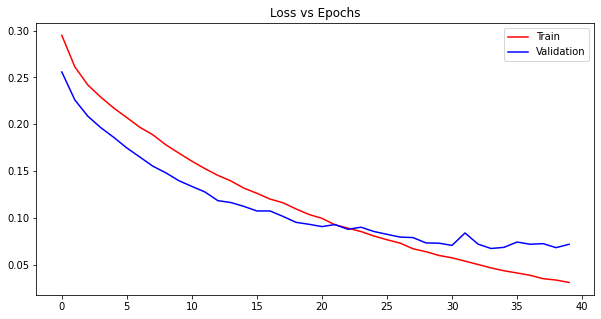

In [24]:
plt.figure(figsize=(10, 5))
plt.plot(cnn['train_loss'], color='r', label='Train')
plt.plot(cnn['valid_loss'], color='b', label='Validation')
plt.title('Loss vs Epochs')
plt.legend(loc="best")
plt.savefig("drive/MyDrive/datasets/pictures/Training Loss vs Epochs")
plt.show()

### Accuracy

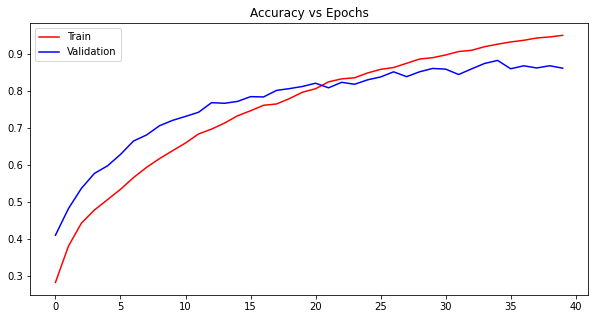

In [25]:
plt.figure(figsize=(10, 5))
plt.plot(cnn['train_accu'], color='r', label='Train')
plt.plot(cnn['valid_accu'], color='b', label='Validation')
plt.title('Accuracy vs Epochs')
plt.legend(loc="best")
plt.savefig("drive/MyDrive/datasets/pictures/Training Accuracy vs Epochs")
plt.show()

### Confusion Matrix

In [26]:
cnn_m = np.zeros((10, 10))
with open(Para.LOG_SAVE_FOLDER + 'CnnMatrix.json', 'r') as f:
    cnn_l = json.load(f)

for point in cnn_l:
    i, j = point
    cnn_m[i][j] += 1

cnn_m/=sum(cnn_m)

cnn_m = pd.DataFrame(cnn_m, index = [Para.dictionary.get(i) for i in range(10)],
                  columns = [Para.dictionary.get(i) for i in range(10)],)

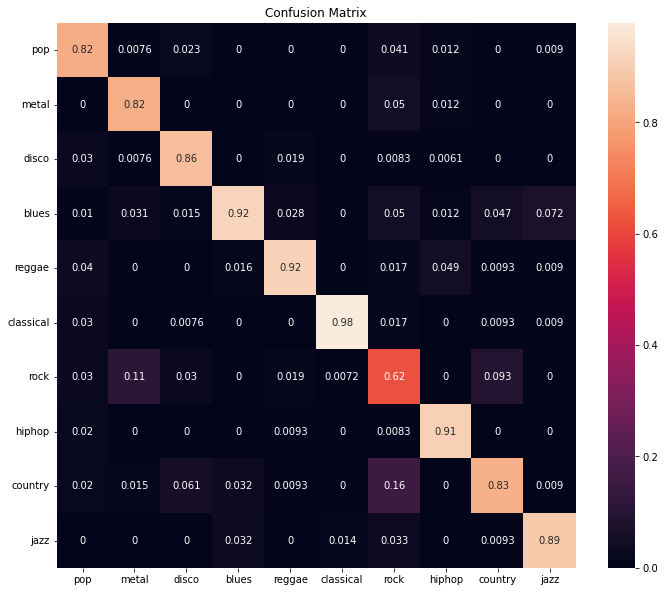

In [30]:
plt.figure(figsize=(10, 24))
plt.subplot(3, 1, 1)
plt.title('Confusion Matrix')
sn.heatmap(cnn_m, annot=True,)
plt.tight_layout()
plt.savefig("drive/MyDrive/datasets/pictures/matrix")

## Full Song Test

### Accuracy of each genre

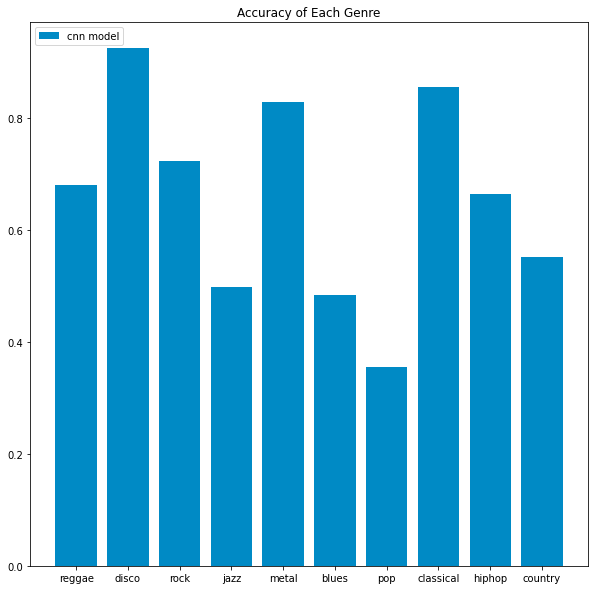

In [32]:
with open(Para.LOG_SAVE_FOLDER + 'cnnFullSongTest.json', 'r') as f:
    cnnFullSongTest = json.load(f)

plt.figure(figsize=(10, 10))
plt.bar(range(len(cnnFullSongTest)), cnnFullSongTest.values(), 
        align='center', 
        color= '#008ac5',
        label='cnn model')
plt.xticks(range(len(cnnFullSongTest)), cnnFullSongTest.keys())
plt.title("Accuracy of Each Genre")
plt.legend(loc="upper left")
plt.savefig("drive/MyDrive/datasets/pictures/Accuracy of Each Genre")
plt.show()